In [70]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from adjustText import adjust_text
from scipy.stats import kendalltau, pearsonr

In [71]:
country = "France"
location_level = "department_id"
method = "nv"
year = 2022

colors = json.load(open("consts.json", encoding="utf-8"))

In [72]:
gdf = gpd.read_file(f"geo_shapes/{country}_department.gpkg")
gdf.head()

,department_id,department,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ..."


In [73]:
df = pd.read_csv(f"data_output/{country}/{year}_divisiveness_{location_level}_{method}.csv.gz", compression="gzip")
df["department_id"] = df["department_id"].str.zfill(2)
df = df.dropna()
df["rank"] = df.groupby(location_level)["value"].rank(ascending=False).astype(int)
df.head()

,candidate,value,weight,type,mean,department_id,rank
0,Anne HIDALGO,0.923948,0.016948,Between,0.016948,01,6
2,Emmanuel MACRON,0.770787,0.276875,Between,0.276875,01,12
4,Fabien ROUSSEL,0.924705,0.017831,Between,0.017831,01,5
6,Jean LASSALLE,0.927051,0.032658,Between,0.032658,01,1
8,Jean-Luc MÉLENCHON,0.845893,0.173657,Between,0.173657,01,10


In [74]:
df_fround = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz", compression="gzip")
df_fround.columns = [x.lower() for x in df_fround.columns]

df_runoff = pd.read_csv(f"data_output/{country}/{year}_runoff.csv.gz", compression="gzip")
df_runoff.columns = [x.lower() for x in df_runoff.columns]

candidate_a, candidate_b = df_runoff.candidate.unique()
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")

df_fround = pd.merge(df_fround, df_location, on="polling_id")

df_location = pd.read_csv(f"data_output/{country}/{year}_runoff_location.csv.gz", compression="gzip")
df_runoff = pd.merge(df_runoff, df_location, on="polling_id")

df_fround["department_id"] = df_fround["department_id"].str.zfill(2)
df_runoff["department_id"] = df_runoff["department_id"].str.zfill(2)

C:\Users\cnava\AppData\Local\Temp\ipykernel_33304\3483063396.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")
C:\Users\cnava\AppData\Local\Temp\ipykernel_33304\3483063396.py:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv(f"data_output/{country}/{year}_runoff_location.csv.gz", compression="gzip")


In [75]:
def create_geoplot(data, ax, title, char=""):
    data = gpd.GeoDataFrame(data)
    plot = data.plot(
        column="candidate",
        color=data["color"],
        edgecolor="black",
        lw=0.2,
        ax=ax, 
        legend=True, 
        legend_kwds=dict()
    )
    plot.axis("off")

    ax.set_title(title)
    ax.text(.01, .99, char, weight="bold", fontsize=16, ha="left", va="top", transform=ax.transAxes)
    return plot

C:\Users\cnava\AppData\Roaming\Python\Python310\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\cnava\AppData\Roaming\Python\Python310\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\cnava\AppData\Roaming\Python\Python310\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


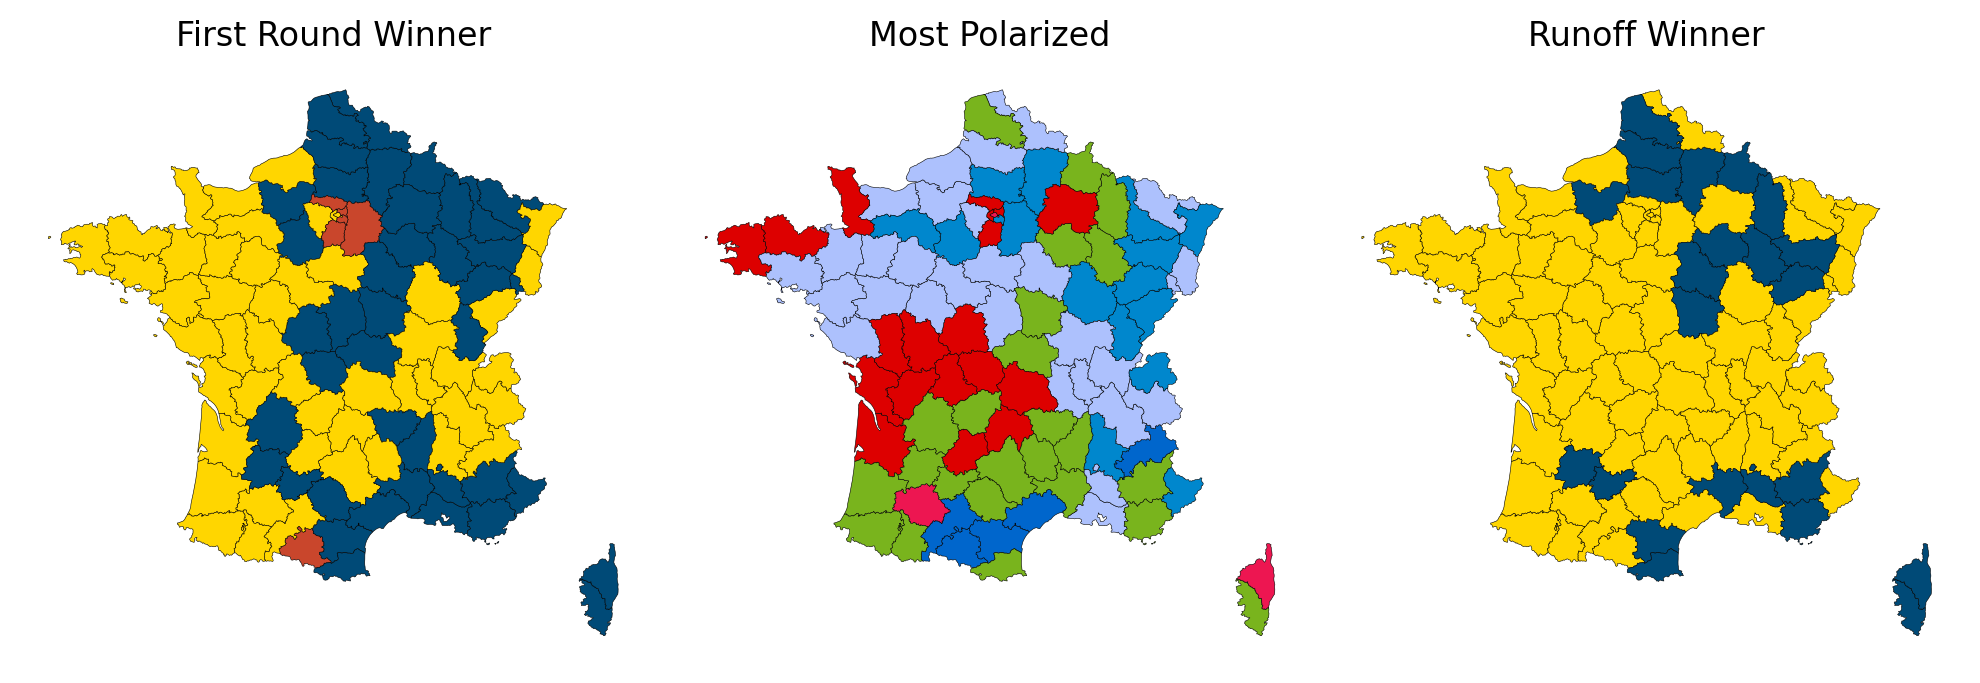

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 30), dpi=200)

dd = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"})
dd["rank"] = dd.groupby(level=0)["value"].rank(ascending=False).astype(int)
dd = dd.reset_index()

data_tmp = dd[dd["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp["color"] = data_tmp["candidate"].replace(colors)

create_geoplot(data_tmp, axs[0], "First Round Winner", "")

data_tmp = df[df["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp["color"] = data_tmp["candidate"].replace(colors)

create_geoplot(data_tmp, axs[1], "Most Polarized", "")

dd = df_runoff.groupby([location_level, "candidate"]).agg({"value": "sum"})
dd["rank"] = dd.groupby(level=0)["value"].rank(ascending=False).astype(int)
dd = dd.reset_index()

data_tmp = dd[dd["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp["color"] = data_tmp["candidate"].replace(colors)

create_geoplot(data_tmp, axs[2], "Runoff Winner", "")

fig.tight_layout()

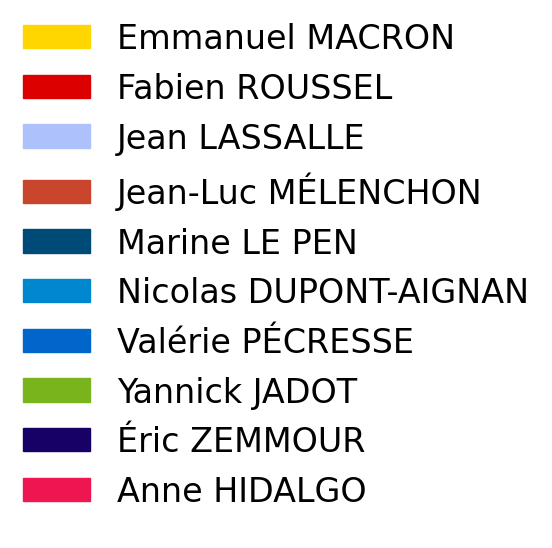

In [77]:
#Imports
import matplotlib.patches as mpatches

# where some data has already been plotted to ax
handles, labels = axs[1].get_legend_handles_labels()

for key in colors.keys():
    if key in df["candidate"].unique():
        value = colors[key]
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch) 
        
legend = plt.legend(handles=handles, loc='lower center', fontsize=24, frameon=False, ncol=1)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.axis("off")
# export_legend(legend)
# plt.show()
legend

In [85]:
# data = df[~df[location_level].str.contains("Z")]
# data = data[~data[location_level].isin(["2A", "2B"])]
# dd = data.pivot(index="candidate", columns=location_level, values="value").corr().reset_index()\
#     .rename(columns={"department_id": "source"}).melt(id_vars="source")
# dd.columns = ["source", "target", "weight"]
# dd = dd[dd["source"] > dd["target"]]
# dd

In [86]:
# dd.sort_values("weight").tail(int(dd.shape[0] / 10))

In [80]:
# fig, ax = plt.subplots(figsize=(8, 8), dpi=96)

# data_tmp = df[df["candidate"] == "ROBERT HUE"]
# data_tmp = pd.merge(data_tmp, gdf, on=location_level)

# data_tmp = gpd.GeoDataFrame(data_tmp)
# display
# # data_tmp["value"] = NormalizeData(data_tmp["value"])

# data_tmp.plot(
#     column="value", 
#     edgecolor="black",
#     cmap="cividis",
#     lw=0.2,
#     ax=ax, 
#     legend=True, 
#     legend_kwds=dict(
#         shrink=0.3
#     )
# )

# plt.axis("off")
# plt.show()

In [87]:
df.candidate.unique()

array(['Anne HIDALGO', 'Emmanuel MACRON', 'Fabien ROUSSEL',
       'Jean LASSALLE', 'Jean-Luc MÉLENCHON', 'Marine LE PEN',
       'Nathalie ARTHAUD', 'Nicolas DUPONT-AIGNAN', 'Philippe POUTOU',
       'Valérie PÉCRESSE', 'Yannick JADOT', 'Éric ZEMMOUR'], dtype=object)

(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

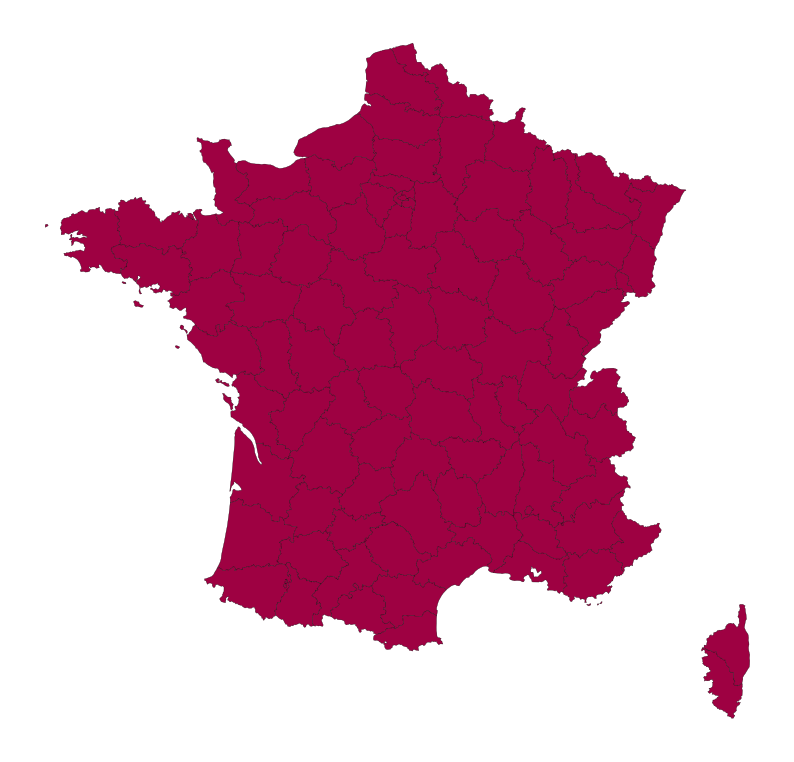

In [82]:
data_tmp = df.groupby("department_id").agg({"value": "sum"}).reset_index()
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp = gpd.GeoDataFrame(data_tmp)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp.plot(
    column="value",
    edgecolor="black",
    lw=0.2,
    vmin=0.2,
    vmax=0.4,
    ax=ax, 
    cmap="Spectral_r",
    legend=False, 
    legend_kwds=dict(
        shrink=0.3
    )
)

ax.axis("off")


In [91]:
df.type.unique()

array(['Between'], dtype=object)

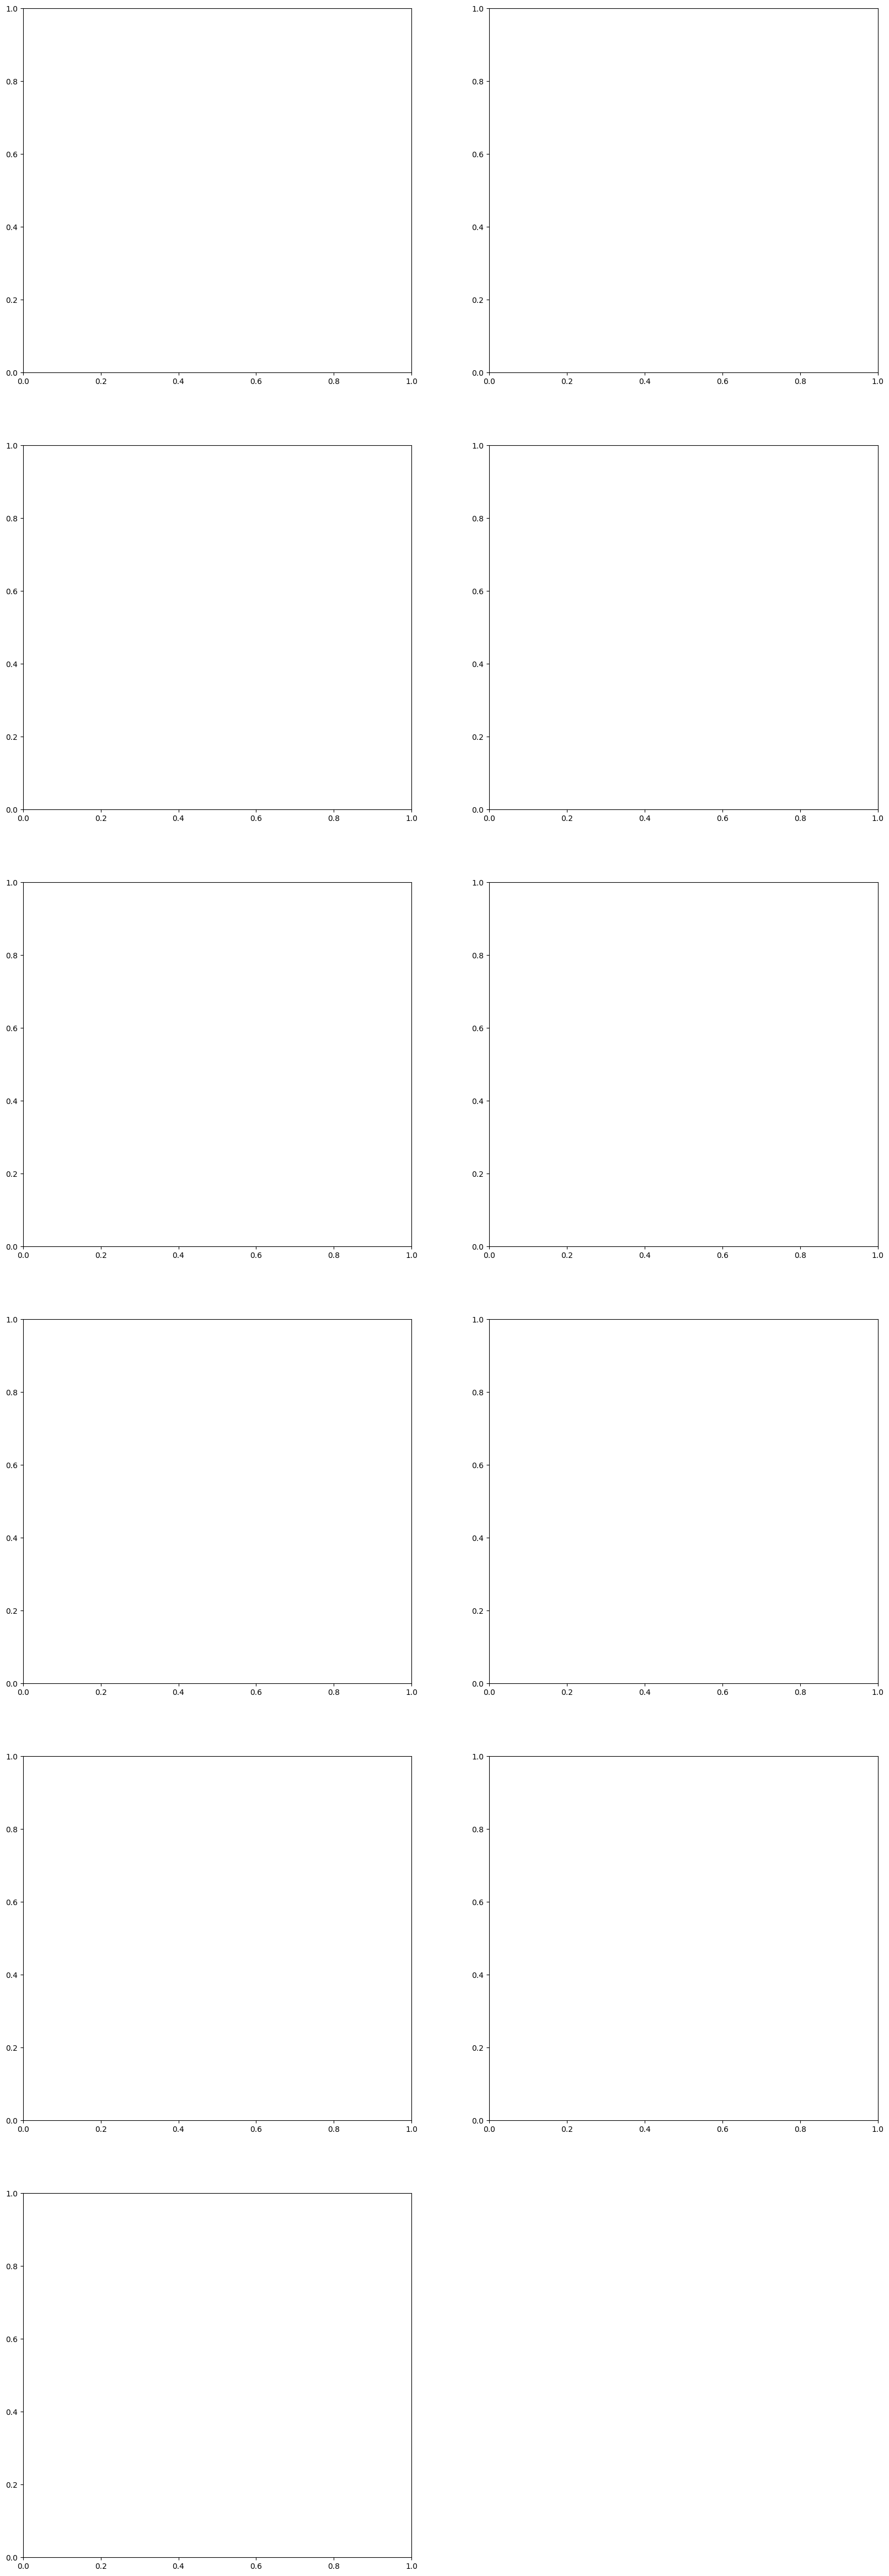

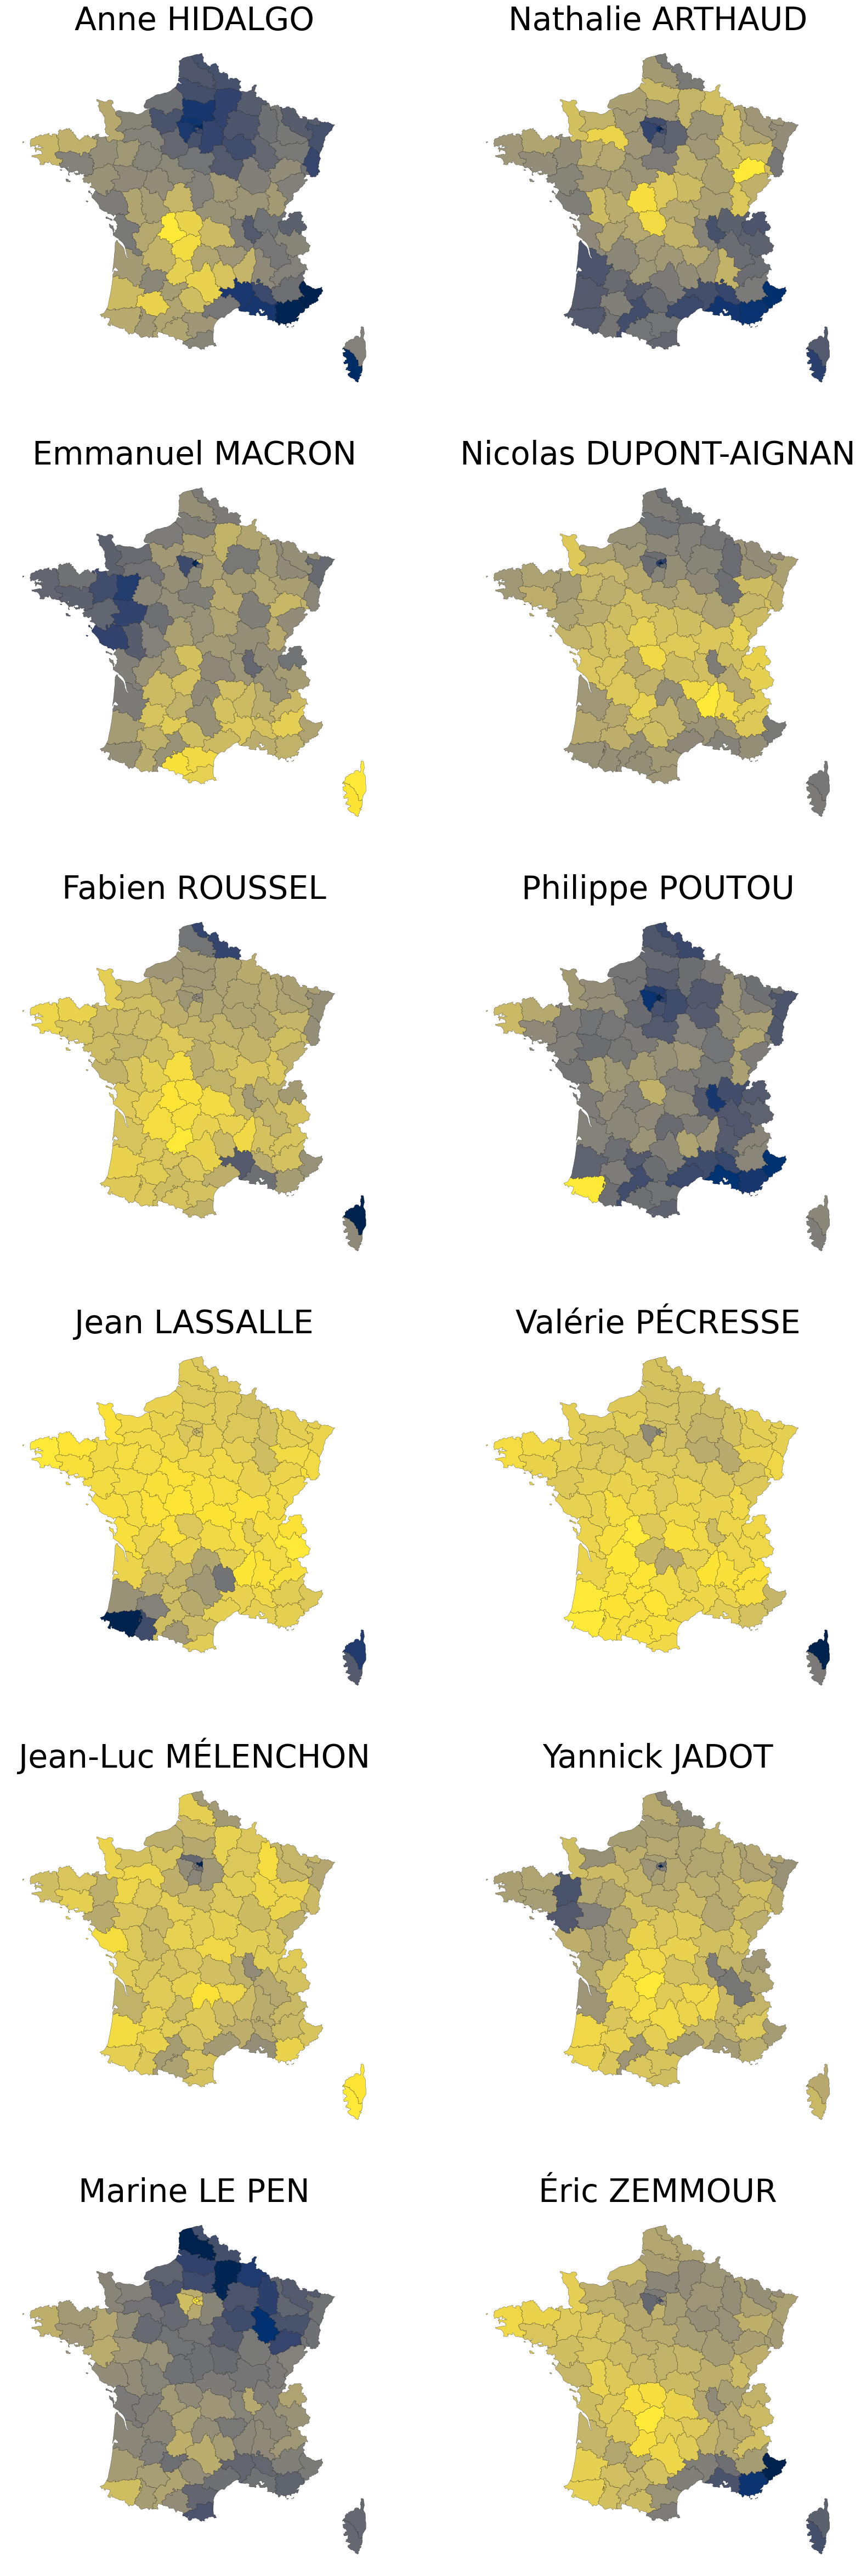

In [90]:
for ttype in ["Within", "Between"]:
    fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), dpi=100)
    i = 0

    for candidate in df.candidate.unique():
        data_tmp = df[(df["candidate"] == candidate) & (df["type"] == ttype)]
        data_tmp = pd.merge(data_tmp, gdf, on=location_level)
        data_tmp = gpd.GeoDataFrame(data_tmp)
        # display(data_tmp)

        if data_tmp.shape[0] > 0:

            ax = axs[i%6, int(i/6)]
            i += 1

            data_tmp.plot(
                column="value",
                edgecolor="black",
                lw=0.2,
                # vmin=0,
                # vmax=1,
                ax=ax, 
                cmap="cividis",
                legend=False, 
                legend_kwds=dict(
                    shrink=0.3
                )
            )
            ax.patch.set_alpha(0.0)
            ax.axis("off")
            ax.set_title(candidate, fontsize=42)
    plt.axis("off")
    fig

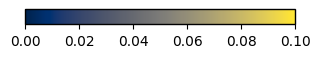

In [ ]:
import pylab as pl
import numpy as np

a = np.array([[0.0, 0.1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap="cividis")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.3, 0.1])

cb = pl.colorbar(orientation="horizontal", cax=cax)
cb.outline.set_color("#000000")
cb.outline.set_linewidth(1)

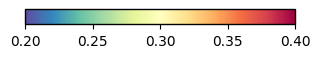

In [ ]:
import pylab as pl
import numpy as np

a = np.array([[0.2, 0.4]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap="Spectral_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.3, 0.1])

cb = pl.colorbar(orientation="horizontal", cax=cax)
cb.outline.set_color("#000000")
cb.outline.set_linewidth(1)

In [ ]:
df_transition = pd.read_csv(f"data_transition/{country}_{year}_department_id_expanded.csv", encoding="latin-1")
df_transition.head()

,Unnamed: 0,Nathalie.ARTHAUD.Emmanuel.MACRON,Fabien.ROUSSEL.Emmanuel.MACRON,Emmanuel.MACRON.Emmanuel.MACRON,Jean.LASSALLE.Emmanuel.MACRON,Marine.LE.PEN.Emmanuel.MACRON,Éric.ZEMMOUR.Emmanuel.MACRON,Jean.Luc.MÉLENCHON.Emmanuel.MACRON,Anne.HIDALGO.Emmanuel.MACRON,Yannick.JADOT.Emmanuel.MACRON,...,Jean.LASSALLE.Marine.LE.PEN,Marine.LE.PEN.Marine.LE.PEN,Éric.ZEMMOUR.Marine.LE.PEN,Jean.Luc.MÉLENCHON.Marine.LE.PEN,Anne.HIDALGO.Marine.LE.PEN,Yannick.JADOT.Marine.LE.PEN,Valérie.PÉCRESSE.Marine.LE.PEN,Philippe.POUTOU.Marine.LE.PEN,Nicolas.DUPONT.AIGNAN.Marine.LE.PEN,department_id
0,1,0,0.462799,0.920431,0.399662,0,0.241726,0.812079,0.543031,0.987694,...,0.576302,0.992662,0.757577,0.186265,0.432378,0,0,0.744773,0.988994,01
1,2,0,0.247988,0.883910,0.292247,0,0.095996,0.733322,0.462405,0.982231,...,0.707753,1.000000,0.902094,0.266678,0.529446,0,0,0.826343,1.000000,02
2,3,0,0.447471,0.911682,0.341199,0,0.204412,0.807793,0.486873,0.987746,...,0.653403,1.000000,0.793359,0.190671,0.498413,0,0,0.781296,0.990476,03
3,4,0,0.354856,0.914200,0.291323,0,0.146793,0.732674,0.476241,0.983525,...,0.708677,1.000000,0.850481,0.267326,0.511709,0,0,0.802960,0.998603,04
4,5,0,0.330715,0.930982,0.306758,0,0.162164,0.772897,0.473273,0.985683,...,0.693242,0.993290,0.835054,0.227094,0.515397,0,0,0.800649,0.996697,05


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

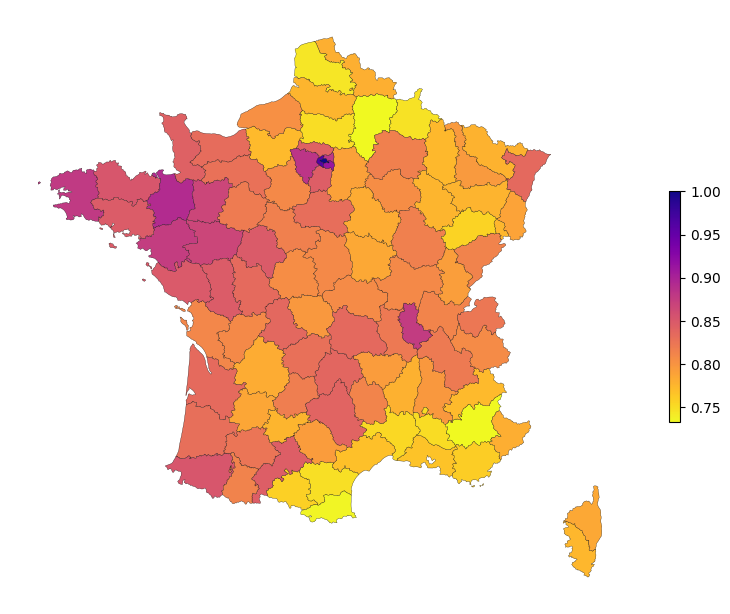

In [ ]:

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = pd.merge(df_transition, gdf, on="department_id")

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="Jean.Luc.MÉLENCHON.Emmanuel.MACRON", 
    edgecolor="black",
    cmap="plasma_r",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
        shrink=0.3
    )
)

plt.axis("off")

In [ ]:
# aa[aa["candidate"] == "Jean-Luc MÉLENCHON"].sort_values("Jean.Luc.MÉLENCHON.Emmanuel.MACRON")

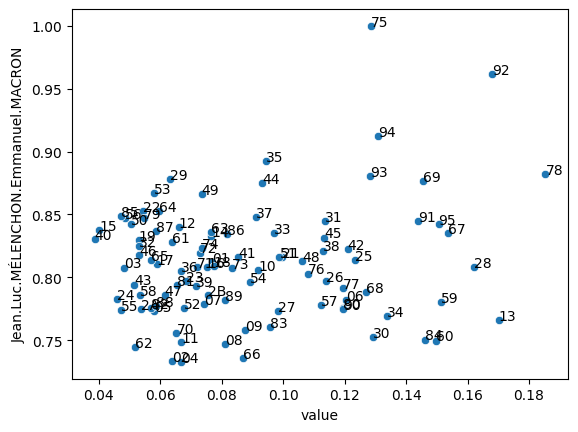

In [ ]:
aa = pd.merge(df_transition, df, on="department_id")
aa = aa[~aa["department_id"].isin(["ZZ", "ZD", "ZA", "ZB", "ZC", "ZX", "ZS", "ZP", "ZN", "ZW", "ZM"])]
# display(aa[aa["candidate"] == "Jean-Luc MÉLENCHON"].corr())
g = sns.scatterplot(x="value", y="Jean.Luc.MÉLENCHON.Emmanuel.MACRON", data=aa[aa["candidate"] == "Jean-Luc MÉLENCHON"])
# g.set_xscale("log")
# g.set_yscale("log")
for x, tmp in aa[aa["candidate"] == "Jean-Luc MÉLENCHON"].iterrows():
    g.text(tmp["value"], tmp["Jean.Luc.MÉLENCHON.Emmanuel.MACRON"], tmp["department_id"])

In [ ]:
endorsements = {
    "Emmanuel MACRON": [("Anne HIDALGO", "Yannick JADOT", "Valérie PÉCRESSE"), ("Jean-Luc MÉLENCHON", "Philippe POUTOU", "Fabien ROUSSEL")],
    "Marine LE PEN": [("Nicolas DUPONT-AIGNAN", "Éric ZEMMOUR"), ()]
}

aa = df_fround[df_fround["candidate"].isin(endorsements[candidate_a][0])].groupby("polling_id").agg({"rate": "sum"})
aa = aa.reset_index()
aa = aa.rename(columns={"rate": candidate_a})

bb = df_fround[df_fround["candidate"].isin(endorsements[candidate_b][0])].groupby("polling_id").agg({"rate": "sum"})
bb = bb.reset_index()
bb = bb.rename(columns={"rate": candidate_b})


df_endorsement = pd.merge(aa, bb, on="polling_id")
df_endorsement

,polling_id,Emmanuel MACRON,Marine LE PEN
0,01-1-0001,0.117308,0.123077
1,01-10-0001,0.069079,0.116776
2,01-100-0001,0.102041,0.081633
3,01-101-0001,0.109244,0.142857
4,01-102-0001,0.120623,0.070039
...,...,...,...
69677,ZZ-94-0001,0.000000,0.000000
69678,ZZ-95-0001,0.163934,0.163934
69679,ZZ-96-0001,0.100000,0.075000
69680,ZZ-98-0001,0.073171,0.097561


In [ ]:
df.candidate.unique()

array(['Emmanuel MACRON', 'Fabien ROUSSEL', 'Jean LASSALLE',
       'Jean-Luc MÉLENCHON', 'Marine LE PEN', 'Nicolas DUPONT-AIGNAN',
       'Valérie PÉCRESSE', 'Yannick JADOT', 'Éric ZEMMOUR'], dtype=object)

In [ ]:
locations = {
    "Marine LE PEN": (50.5135965, 1.8115089),
    "Jean-Luc MÉLENCHON": (43.2802598, 5.2405645)
}
import geopy.distance

ModuleNotFoundError: No module named 'geopy'

In [ ]:
# aa = pd.merge(gdf, asd, on="department")

# outp = []
# for i, item in aa.iterrows():
#     coords_1 = (item["latitude"], item["longitude"])
#     coords_2 = (43.2802598, 5.2405645)
#     kms = geopy.distance.geodesic(coords_1, coords_2).km
#     outp.append(kms)
    
# aa["distance"] = outp

# # aa[aa["candidate"] == "Jean-Luc MÉLENCHON"].to_csv("distance.csv", index=False)

In [ ]:
output = []
country = "France"
location_level = "department"
for index, row in gdf.to_crs(epsg=4326).iterrows():
    point = row.geometry.centroid
    longitude = point.x
    latitude = point.y
    output.append({
        "latitude": latitude,
        "longitude": longitude,
        location_level: row[location_level]
    })
asd = pd.DataFrame(output)#.to_csv(f"data_distances/{country}_{location_level}.csv", index=False)
asd

In [ ]:
gdf = pd.merge(gdf, df, on=location_level)

In [ ]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(gdf)

# row-normalise weights
W.transform = "r"

# create lag
gdf["averaged_value"] = libpysal.weights.lag_spatial(W, gdf["value"])

In [ ]:
df_test = dd.copy()
df_test["qdv_winner"] = pd.qcut(df_test["dv_winner"], 9).astype(str)
df_test["qdv_loser"] = pd.qcut(df_test["dv_loser"], 9).astype(str)
m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(9.5, 8))
g = sns.heatmap(m, cmap="plasma")
g.invert_yaxis()
g.set_xlabel("Divisiveness (%) Winner")
g.set_ylabel("Divisiveness (%) Loser")
g.set_xticklabels([])
g.set_yticklabels([])
g

In [ ]:
df_test = dd.copy().dropna()
df_test["qdv_winner"] = pd.qcut(df_test["rate_winner"], 10).astype(str)
df_test["qdv_loser"] = pd.qcut(df_test["rate_loser"], 10).astype(str)
m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(9.5, 8))
g = sns.heatmap(m, cmap="plasma")
g.invert_yaxis()
g.set_xlabel("Rate (%) Winner")
g.set_ylabel("Rate (%) Loser")
g.set_xticklabels([])
g.set_yticklabels([])
g

In [ ]:
overseas = ["Guadeloupe", "Martinique", "Guyane", "La Réunion", "Mayotte"]


In [ ]:
df_location[["department", "department_id"]].drop_duplicates()

In [ ]:
# data.head(50)

In [ ]:
df_tmp = df.groupby("department").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, df_poverty, on="department")
data = data[~data["department"].isin(overseas)]
data = pd.merge(data, df_location[["department", "department_id"]].drop_duplicates(), on="department")
data = data[~data["department_id"].isin(["2B", "93"])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])

sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "poverty_rate"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x="poverty_rate", s=80, lw=0, y="value", data=data, ax=ax, color="#138303")

ax.set_xlabel("Poverty Rate (%)")
ax.set_ylabel("Divisiveness (Normalized)")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# texts = []
# for x, tmp in data.iterrows():
#     texts.append(ax.text(tmp["poverty_rate"], tmp["value"], tmp["department_id"], fontsize=16, color="#444444"))
    
# adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 

In [ ]:
df_voters = df_location.groupby("department").agg({"electors": "sum", "abstentions": "sum"}).reset_index()

df_part_fround = df_voters.copy()
df_part_fround["abstention"] = (df_part_fround["abstentions"] / df_part_fround["electors"])


In [ ]:
data.sort_values("department_id").tail(50)

In [ ]:
df_tmp = df.groupby("department").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, df_part_fround[["department", "abstention"]], on="department")
data = data[~data["department"].isin(overseas)]
data = pd.merge(data, df_location[["department", "department_id"]].drop_duplicates(), on="department")
data = data[~data["department_id"].isin(["ZZ", "ZX", "ZS", "ZP", "ZN"])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])

sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "abstention"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x=x, s=80, lw=0, y=y, data=data, ax=ax, color="#138303")

ax.set_xlabel("Abstention (%)")
ax.set_ylabel("Divisiveness (Normalized)")

# ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

texts = []
for idx, tmp in data.iterrows():
    texts.append(ax.text(tmp[x], tmp[y], tmp["department_id"], fontsize=16, color="#444444"))
    
adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 

In [ ]:
aa = df_runoff.groupby([location_level, "candidate"]).agg({"value": "sum"})
aa["rate"] = aa.groupby(level=[0]).apply(lambda x: x/x.sum())
aa = aa.reset_index()
aa = aa.pivot(index=location_level, columns="candidate", values="rate").reset_index()
aa["diff"] = aa[candidate_a] - aa[candidate_b]
aa

In [ ]:
bb = df.groupby(location_level).agg({"value": "mean"}).reset_index()
bb

In [ ]:
cc = pd.merge(aa, bb, on=location_level)
cc = cc[~cc["department"].isin(overseas)]

cc["diff_abs"] = np.abs(cc["diff"])
cc["winner"] = cc.apply(lambda x: candidate_a if x[candidate_a] > x[candidate_b] else candidate_b, axis=1)

In [ ]:
cc.corr()

In [ ]:
g = sns.scatterplot(x="value", y="diff_abs", hue="winner", legend=False, data=cc)
g.set_xlabel("Divisiveness")
g.set_ylabel("Diff Candidates")

In [ ]:
gdf_commune = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/communes-version-simplifiee.geojson")
gdf_commune = gdf_commune.rename(columns={"code": "commune_id", "nom": "commune"})
gdf_commune.head()

In [ ]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(asdf)

# row-normalise weights
W.transform = "r"

# create lag
asdf["averaged_value"] = libpysal.weights.lag_spatial(W, asdf["value"])

In [ ]:
asdf = pd.merge(gdf_commune, df, on="commune_id")
asdf

In [ ]:
output = []
country = "France"
location_level = "commune_id"
for index, row in gdf_commune.to_crs(epsg=4326).iterrows():
    if row.geometry:
        point = row.geometry.centroid
        longitude = point.x
        latitude = point.y
        output.append({
            "latitude": latitude,
            "longitude": longitude,
            location_level: row[location_level]
        })
asd = pd.DataFrame(output)#.to_csv(f"data_distances/{country}_{location_level}.csv", index=False)
asd

In [ ]:
gdf_commune[gdf_commune["commune"] == "Toulouse"]

In [ ]:
df_location["commune_id"] = df_location["department_id"].astype(str).str.zfill(2) + df_location["commune_id"].astype(str).str.zfill(3)

In [ ]:
asdf

In [ ]:
aa = pd.merge(asdf, asd, on="commune_id")

outp = []
for i, item in aa.iterrows():
    coords_1 = (item["latitude"], item["longitude"])
    coords_2 = (43.2802598, 5.2405645)
    kms = geopy.distance.geodesic(coords_1, coords_2).km
    outp.append(kms)
    
aa["distance"] = outp

# aa[aa["candidate"] == "Jean-Luc MÉLENCHON"].to_csv("distance.csv", index=False)

In [ ]:
aa[(aa["candidate"] == "Jean-Luc MÉLENCHON")].to_csv("distance.csv", index=False)